<a href="https://colab.research.google.com/github/TienLungSun/Intelligent-Elderly-Care/blob/main/fasterRCNN_slowfast_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ref https://github.com/facebookresearch/pytorchvideo/blob/master/tutorials/video_detection_example/video_detection_inference_tutorial.ipynb

In [28]:
#安裝 Detectron2, takes about 3 min
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-81tawg2q
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-81tawg2q


In [29]:
#執行這一行前, 要把 visualization.py Colab
!python visualization.py

In [30]:
!pip install pytorchvideo

In [31]:
from functools import partial
import numpy as np
import imageio
import cv2
import torch

import detectron2
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor

from IPython import display
import matplotlib.pyplot as plt

In [32]:
import pytorchvideo
from pytorchvideo.transforms.functional import (
    uniform_temporal_subsample,
    short_side_scale_with_boxes,
    clip_boxes_to_image,
)
from torchvision.transforms._functional_video import normalize
from pytorchvideo.data.ava import AvaLabeledVideoFramePaths
from pytorchvideo.models.hub import slow_r50_detection,slowfast_r50_detection # Another option is slowfast_r50_detection

from visualization import VideoVisualizer

#Load Model using Torch Hub API

PyTorchVideo provides several pretrained models through Torch Hub. Available models are described in model zoo documentation.

Here we are selecting the slow_r50_detection model which was trained using a 4x16 setting on the Kinetics 400 dataset and fine tuned on AVA V2.2 actions dataset.

In [33]:
device = 'cuda' # or 'cpu'
video_model = slowfast_r50_detection(True) # Another option is slowfast_r50_detection
#video_model = slow_r50_detection(True) # Another option is slowfast_r50_detection
video_model = video_model.eval().to(device)

#Load an off-the-shelf Detectron2 object detector

We use the object detector to detect bounding boxes for the people. These bounding boxes later feed into our video action detection model. For more details, please refer to the Detectron2's object detection tutorials.

To install Detectron2, please follow the instructions mentioned https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md

In [34]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [35]:
# This method takes in an image and generates the bounding boxes for people in the image.
def get_person_bboxes(inp_img, predictor):
    predictions = predictor(inp_img.cpu().detach().numpy())['instances'].to('cpu')
    boxes = predictions.pred_boxes if predictions.has("pred_boxes") else None
    scores = predictions.scores if predictions.has("scores") else None
    classes = np.array(predictions.pred_classes.tolist() if predictions.has("pred_classes") else None)
    predicted_boxes = boxes[np.logical_and(classes==0, scores>0.75 )].tensor.cpu() # only person
    return predicted_boxes

#Define the transformations for the input required by the model

Before passing the video and bounding boxes into the model we need to apply some input transforms and sample a clip of the correct frame rate in the clip.

Here, below we define a method that can pre-process the clip and bounding boxes. It generates inputs accordingly for both Slow (Resnet) and SlowFast models depending on the parameterization of the variable slow_fast_alpha.

In [36]:
def ava_inference_transform(
    clip, 
    boxes,
    #num_frames = 4, #if using slow_r50_detection, change this to 4
    num_frames = 32, #if using slowfast_r50_detection, change this to 32
    crop_size = 256, 
    data_mean = [0.45, 0.45, 0.45], 
    data_std = [0.225, 0.225, 0.225],
    #slow_fast_alpha = None, #if using slow_r50_detection, change this to None
    slow_fast_alpha = 4, #if using slowfast_r50_detection, change this to 4
):

    boxes = np.array(boxes)
    ori_boxes = boxes.copy()

    # Image [0, 255] -> [0, 1].
    clip = uniform_temporal_subsample(clip, num_frames)
    clip = clip.float()
    clip = clip / 255.0

    height, width = clip.shape[2], clip.shape[3]
    # The format of boxes is [x1, y1, x2, y2]. The input boxes are in the
    # range of [0, width] for x and [0,height] for y
    boxes = clip_boxes_to_image(boxes, height, width)

    # Resize short side to crop_size. Non-local and STRG uses 256.
    clip, boxes = short_side_scale_with_boxes(
        clip,
        size=crop_size,
        boxes=boxes,
    )
    
    # Normalize images by mean and std.
    clip = normalize(
        clip,
        np.array(data_mean, dtype=np.float32),
        np.array(data_std, dtype=np.float32),
    )
    
    boxes = clip_boxes_to_image(
        boxes, clip.shape[2],  clip.shape[3]
    )
    
    # Incase of slowfast, generate both pathways
    if slow_fast_alpha is not None:
        fast_pathway = clip
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            clip,
            1,
            torch.linspace(
                0, clip.shape[1] - 1, clip.shape[1] // slow_fast_alpha
            ).long(),
        )
        clip = [slow_pathway, fast_pathway]
    
    return clip, torch.from_numpy(boxes), ori_boxes

#Setup
Download the id to label mapping for the AVA V2.2 dataset on which the Torch Hub models were finetuned. This will be used to get the category label names from the predicted class ids.

Create a visualizer to visualize and plot the results(labels + bounding boxes).

In [37]:
# Create an id to label name mapping
# 記得把 ava_action_list.txt 上傳到 Colab
label_map, allowed_class_ids = AvaLabeledVideoFramePaths.read_label_map('ava_action_list.txt')

In [38]:
# Create a video visualizer that can plot bounding boxes and visualize actions on bboxes.
video_visualizer = VideoVisualizer(81, label_map, top_k=3, mode="thres",thres=0.5)

#Load an example video

In [39]:
from google.colab import files
uploaded = files.upload()
fnameLst = list(uploaded.keys())
video_name = fnameLst[0]
print(video_name)

Saving RROldies-short.mp4 to RROldies-short.mp4
RROldies-short.mp4


In [40]:
encoded_vid = pytorchvideo.data.encoded_video.EncodedVideo.from_path(video_name)

In [41]:
encoded_vid.get_clip(0,1)['video'].shape

torch.Size([3, 11, 820, 1466])


#Generate bounding boxes and action predictions for all clips in the video.

In [ ]:
vid = imageio.get_reader(video_name, 'ffmpeg')
fps = vid.get_meta_data()['fps']
print(fps)

30.0


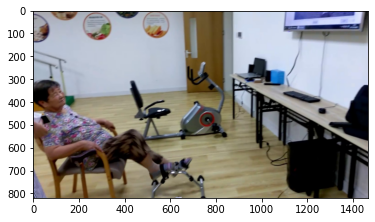

Finished generating predictions.


In [45]:
clip_duration = 1.0 # Duration of clip used for each inference step.
gif_imgs = []
picture_count =0

videoFname = "Result.mp4"  
Writer = imageio.get_writer(videoFname, fps=fps)

# Video predictions are generated at an internal of 1 sec from 0 seconds to the end seconds in the video.
for time_stamp in range(int(encoded_vid.duration)):  # time stamps in video for which clip is sampled. 
    print("Generating predictions for time stamp: {} sec".format(time_stamp))
    
    # Generate clip around the designated time stamps
    inp_imgs = encoded_vid.get_clip(
        time_stamp - clip_duration/2.0, # start second
        time_stamp + clip_duration/2.0  # end second
    )
    inp_imgs = inp_imgs['video']
    
    # Generate people bbox predictions using Detectron2's off the self pre-trained predictor
    # We use the the middle image in each clip to generate the bounding boxes.
    inp_img = inp_imgs[:,inp_imgs.shape[1]//2,:,:]
    inp_img = inp_img.permute(1,2,0)
    
    # Predicted boxes are of the form List[(x_1, y_1, x_2, y_2)]
    predicted_boxes = get_person_bboxes(inp_img, predictor) 
    if len(predicted_boxes) == 0: 
        print("Skipping clip no frames detected at time stamp: ", time_stamp)
        continue
        
    # Preprocess clip and bounding boxes for video action recognition.
    inputs, inp_boxes, _ = ava_inference_transform(inp_imgs, predicted_boxes.numpy())
    # Prepend data sample id for each bounding box. 
    # For more details refere to the RoIAlign in Detectron2
    inp_boxes = torch.cat([torch.zeros(inp_boxes.shape[0],1), inp_boxes], dim=1)
    
    # Generate actions predictions for the bounding boxes in the clip.
    # The model here takes in the pre-processed video clip and the detected bounding boxes.
    if isinstance(inputs, list):
        inputs = [inp.unsqueeze(0).to(device) for inp in inputs]
    else:
        inputs = inputs.unsqueeze(0).to(device)
    preds = video_model(inputs, inp_boxes.to(device))

    preds= preds.to('cpu')
    # The model is trained on AVA and AVA labels are 1 indexed so, prepend 0 to convert to 0 index.
    preds = torch.cat([torch.zeros(preds.shape[0],1), preds], dim=1)
    
    # Plot predictions on the video and save for later visualization.
    inp_imgs = inp_imgs.permute(1,2,3,0)
    inp_imgs = inp_imgs/255.0
    out_img_pred = video_visualizer.draw_clip_range(inp_imgs, preds, predicted_boxes)
    #gif_imgs += out_img_pred
    
    out_img_pred = np.array(out_img_pred)
    for index in range(out_img_pred.shape[0]):
        display.clear_output(wait=True)

        img = out_img_pred[index]
        img = (255*img).astype(np.uint8)
        plt.imshow(img)

        #img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        
        Writer.append_data(img)
        #cv2.imwrite('./output_%s.jpg'%(picture_count), img)
        picture_count += 1

                           
        plt.pause(0.0001)

print("Finished generating predictions.")
Writer.close()

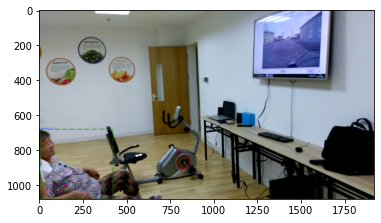

In [ ]:
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img1) 

#Save predictions as video¶
The generated video consists of bounding boxes with predicted actions for each bounding box.

In [ ]:
img = cv2.imread('./frames/output_0.jpg')  # 读取保存的任意一张图片
size = (img.shape[1],img.shape[0])  #获取视频中图片宽高度信息

cap = cv2.VideoCapture(video_name)
total_frames = int(cap.get(7))
vid = imageio.get_reader(video_name, 'ffmpeg')
fps = vid.get_meta_data()['fps']
fourcc = cv2.VideoWriter_fourcc(*"DIVX") # 视频编码格式
videoWrite = cv2.VideoWriter('./%s_modellargeoutput.mp4'%(video_name),fourcc,fps,size)# 根据图片的大小，创建写入对象 （文件名，支持的编码器，帧率，视频大小（图片大小））

for i in range(0, total_frames):
    fileName = "./frames/output_"+str(i)+'.jpg'    #循环读取所有的图片,假设以数字顺序命名
    img = cv2.imread(fileName)
    videoWrite.write(img)# 将图片写入所创建的视频对象
videoWrite.release()

FileNotFoundError: ignored